<a href="https://colab.research.google.com/github/mohameddhameem/algorithmic-trading/blob/main/ML%20Based%20Approach/deep_learning_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  plotly pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import plotly.graph_objs as go
from pandas_datareader import data, wb
print('TF version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

TF version: 2.8.2


## Data Import

For all of our assesment we will use Google's stock data.

In [3]:
start = pd.to_datetime('2000-01-01')
end = pd.to_datetime('2022-07-01')
#Set your tickers
tickers = ['SPY']

In [4]:
def plot_data_for_visualization(data):
    data['Middle Band'] = data['Close'].rolling(window=21).mean()
    data['Upper Band'] = data['Middle Band'] + \
        1.96*data['Close'].rolling(window=21).std()
    data['Lower Band'] = data['Middle Band'] - \
        1.96*data['Close'].rolling(window=21).std()
    data['MA5'] = data['Close'].rolling(5).mean()
    data['MA20'] = data['Close'].rolling(20).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['MA200'] = data['Close'].rolling(200).mean()
    # declare figure
    fig = go.Figure()

    # Candlestick
    fig.add_trace(go.Candlestick(x=data.index,
                                 open=data['Open'],
                                 high=data['High'],
                                 low=data['Low'],
                                 close=data['Close'], name='market data'))
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        )
    )
    # Learn more about deathline and goldencross at:
    # https://www.investopedia.com/ask/answers/121114/what-difference-between-golden-cross-and-death-cross-pattern.asp
    fig.add_trace(go.Scatter(x=data.index, y=data['MA200'], line=dict(
        color='blue', width=1.5), name='Death Line'))
    fig.add_trace(go.Scatter(x=data.index, y=data['MA50'], line=dict(
        color='orange', width=1.5), name='Gold Line'))

    # Show
    fig.show()


In [5]:
length = len(tickers) 
i = 0
while i < length:
    ticker = tickers[i]
    print(f'Downloading data for {ticker}')
    try:
        #Create Variable in which each dataframe will be stored
        locals()[str(tickers[i])+"_data"] = data.DataReader(tickers[i],'yahoo' ,start=start, end=end)
        #Create a CSV file in which you are going to store your dataframe in order to keep track of the change overtime.
        locals()[str(tickers[i])+"_data"].to_csv(str(tickers[i])+"_data.csv")
        i += 1
    except:
        print('Error downloading data for {}'.format(ticker))
        i += 1


Error downloading data for SPY


In [6]:
SPY_data = pd.read_csv('SPY_data.csv')
SPY_data.set_index('Date', inplace=True)
plot_data_for_visualization(SPY_data)
#GOOG_data.tail()


## Data Set Preparation for Training

In [7]:
df = pd.read_csv('SPY_data.csv', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (4530, 5)
Validation data shape: (566, 5)
Test data shape: (566, 5)


### Plot daily changes of close prices and volume


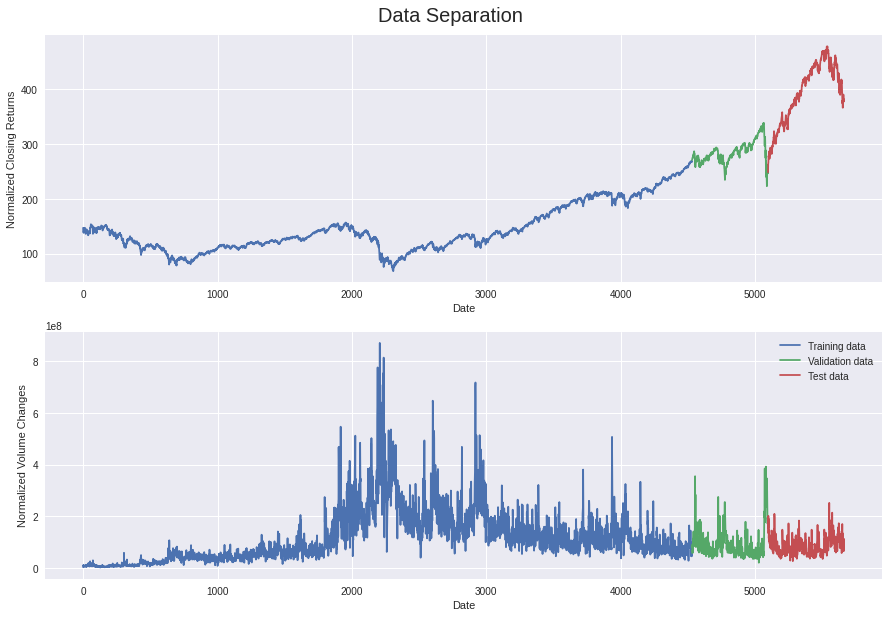

In [8]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')

plt.legend(loc='best')

## Create chunks of training, validation and test data


In [9]:
# Training data
seq_len = 128 # 128 timesteps
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4402, 128, 5) (4402,)
(438, 128, 5) (438,)


## First Model - Bidirectional LSTM

In [22]:
def create_BiLSTM_model():
  in_seq = Input(shape = (seq_len, 5))
      
  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) 
          
  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)      

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])    
  return model

def run_model(in_model):
  callback = tf.keras.callbacks.ModelCheckpoint(f'{in_model}.hdf5', monitor='val_loss',
                                                save_best_only=True, verbose=0)
  in_model.fit(X_train, y_train,
                batch_size=2048,
                verbose=0,
                callbacks=[callback],
                epochs=200,
                #shuffle=True, # DO NOT SHUFFLE DURING TRAINING THE TIME SERIES DATA
                validation_data=(X_val, y_val),) 
  train_pred = in_model.predict(X_train)
  val_pred = in_model.predict(X_val)
  test_pred = in_model.predict(X_test)

  #Print evaluation metrics for all datasets
  train_eval = in_model.evaluate(X_train, y_train, verbose=0)
  val_eval = in_model.evaluate(X_val, y_val, verbose=0)
  test_eval = in_model.evaluate(X_test, y_test, verbose=0)
  print(' ')
  print('Evaluation metrics')
  print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
  print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
  print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))
  fig = plt.figure(figsize=(15,15))
  st = fig.suptitle("Bi-LSTM Model", fontsize=22)
  st.set_y(1.02)

  #Plot training data results
  ax11 = fig.add_subplot(311)
  ax11.plot(train_data[:, 3], label='Closing Returns')
  ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted Closing Returns')
  ax11.set_title("Training Data", fontsize=18)
  ax11.set_xlabel('Date')
  ax11.set_ylabel('Closing Returns')

  #Plot validation data results
  ax21 = fig.add_subplot(312)
  ax21.plot(val_data[:, 3], label='Closing Returns')
  ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted Closing Returns')
  ax21.set_title("Validation Data", fontsize=18)
  ax21.set_xlabel('Date')
  ax21.set_ylabel('Closing Returns')

  #Plot test data results
  ax31 = fig.add_subplot(313)
  ax31.plot(test_data[:, 3], label='Closing Returns')
  ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted Closing Returns')
  ax31.set_title("Test Data", fontsize=18)
  ax31.set_xlabel('Date')
  ax31.set_ylabel('Closing Returns')

  plt.tight_layout()
  plt.legend(loc='best')

 
Evaluation metrics
Training Data - Loss: 1889.2350, MAE: 34.9597, MAPE: 25.0043
Validation Data - Loss: 21481.7324, MAE: 145.1096, MAPE: 49.9560
Test Data - Loss: 75734.6406, MAE: 272.8104, MAPE: 65.1959


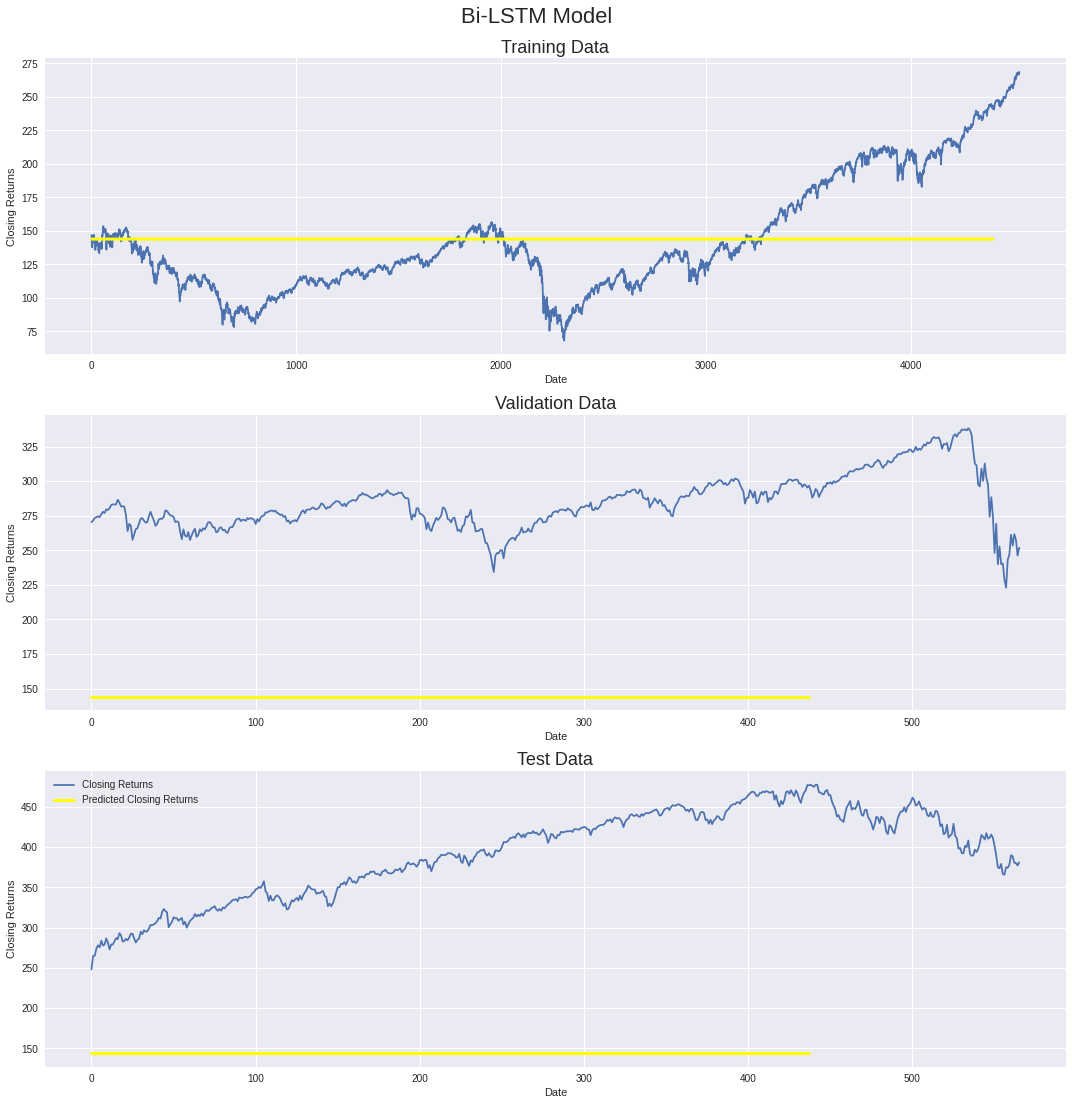

In [23]:
bi_lstm_model = create_BiLSTM_model()
bi_lstm_model = run_model(bi_lstm_model)